In [50]:
# 📦 Базовые библиотеки
import os
from pathlib import Path
import numpy as np
import pandas as pd

# 📊 Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# 🧠 TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.applications import MobileNetV2

# 📈 Метрики
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score
)


# ЭТАП 1. Анализ и подготовка данных

## 1.1 📁 Загрузка и обзор структуры данных

In [2]:
for folder in ['train', 'val', 'test']:
    path = f"/kaggle/input/chest-xray-pneumonia/chest_xray/{folder}"
    counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in ['NORMAL', 'PNEUMONIA']}
    print(f"{folder} set:", counts)

train set: {'NORMAL': 1341, 'PNEUMONIA': 3875}
val set: {'NORMAL': 8, 'PNEUMONIA': 8}
test set: {'NORMAL': 234, 'PNEUMONIA': 390}


Датасет уже разбит на три подмножества. В тренировочной выборке сильный дисбаланс классов: снимков с пневмонией в 3+ раза больше, чем нормальных. Это важно учесть при обучении модели (например, через веса классов или аугментации).

## 1.2 📊 Визуализация дисбаланса классов

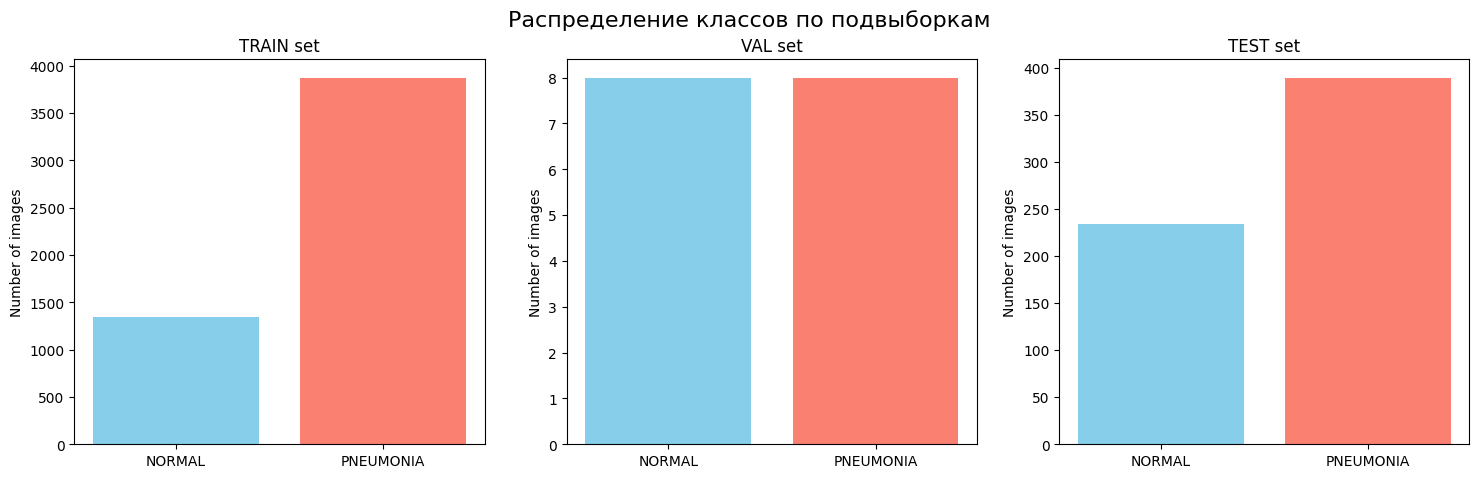

In [3]:
labels = ['NORMAL', 'PNEUMONIA']
paths = {f: f"/kaggle/input/chest-xray-pneumonia/chest_xray/{f}" for f in ['train', 'val', 'test']}

fig, axs = plt.subplots(1, 3, figsize=(18,5))
for i, (split, path) in enumerate(paths.items()):
    counts = [len(os.listdir(os.path.join(path, label))) for label in labels]
    axs[i].bar(labels, counts, color=['skyblue', 'salmon'])
    axs[i].set_title(f'{split.upper()} set')
    axs[i].set_ylabel('Number of images')
plt.suptitle('Распределение классов по подвыборкам', fontsize=16)
plt.show()

Обнаружен дисбаланс в train.

val и test сбалансированы — подходят для честной валидации и оценки.

## 1.3 🖼️ Примеры изображений из каждого класса

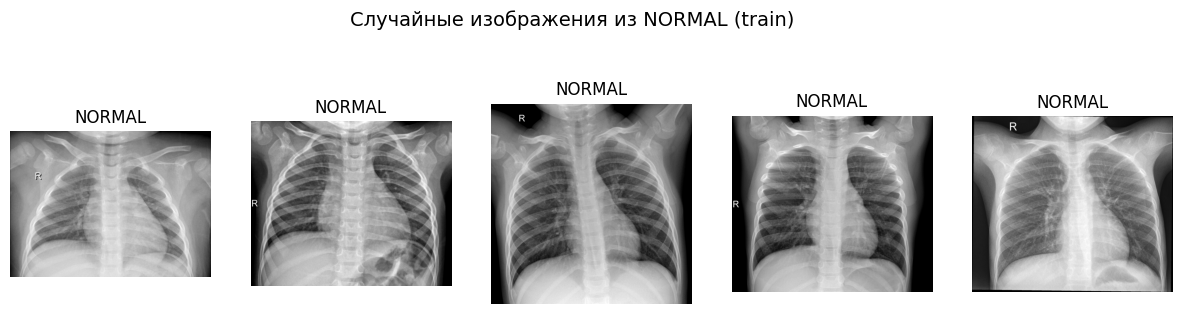

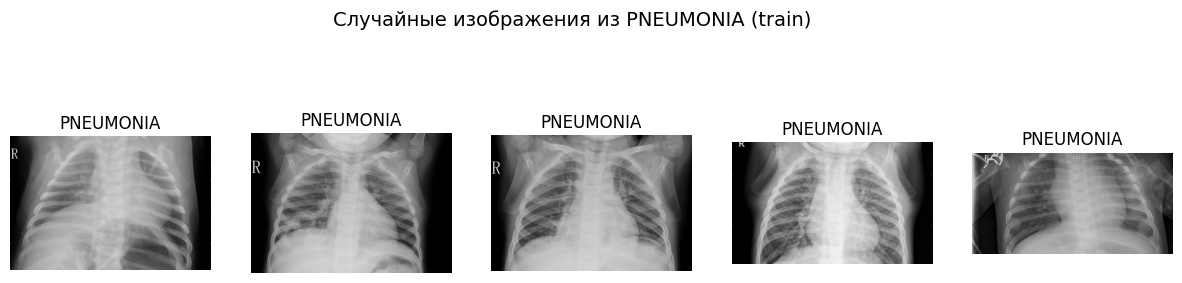

In [4]:
def show_random_images(label, n=5, dataset='train'):
    folder = f"/kaggle/input/chest-xray-pneumonia/chest_xray/{dataset}/{label}"
    images = os.listdir(folder)
    selected = np.random.choice(images, n)
    
    plt.figure(figsize=(15,4))
    for i, img_name in enumerate(selected):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{label}")
        plt.axis('off')
    plt.suptitle(f"Случайные изображения из {label} ({dataset})", fontsize=14)
    plt.show()

show_random_images('NORMAL')
show_random_images('PNEUMONIA')

У NORMAL снимков лёгкие прозрачные, симметричные.

У PNEUMONIA часто встречается затемнение, асимметрия, более тёмные и неструктурированные участки.

## 1.4 ⚠️ Поиск атипичных или подозрительных снимков

Мы будем искать:

* почти пустые изображения (низкая яркость)

* слишком яркие

* пересвеченные или тёмные (низкое/высокое среднее значение)

* очень малый разброс (std)

In [6]:
def find_suspicious_images(label, dataset='train', threshold_std=15, threshold_mean_dark=40, threshold_mean_bright=220):
    path = Path(f"/kaggle/input/chest-xray-pneumonia/chest_xray/{dataset}/{label}")
    files = list(path.glob("*.jpeg"))
    suspicious = []

    for file in files:
        try:
            img = Image.open(file).convert("L")  # grayscale
            img_arr = np.array(img)
            mean = np.mean(img_arr)
            std = np.std(img_arr)

            if std < threshold_std or mean < threshold_mean_dark or mean > threshold_mean_bright:
                suspicious.append((file.name, mean, std))
        except Exception as e:
            suspicious.append((file.name, 'Unreadable', str(e)))

    return suspicious

In [7]:
sus_normal = find_suspicious_images('NORMAL')
sus_pneumonia = find_suspicious_images('PNEUMONIA')

print("⚠️ Подозрительные NORMAL:", sus_normal[:5])
print("⚠️ Подозрительные PNEUMONIA:", sus_pneumonia[:5])

⚠️ Подозрительные NORMAL: []
⚠️ Подозрительные PNEUMONIA: [('person1413_bacteria_3615.jpeg', 221.53662337662337, 20.415354379548997)]


Это позволяет выявить неинформативные или странные снимки, даже если они физически корректны.

Примеры:

* std < 15 → почти пустое или очень равномерное изображение

* mean < 40 → чересчур тёмное (возможно, неудачный снимок)

* mean > 220 → пересвечено

### 📷 Визуализация подозрительных:

<Figure size 1500x400 with 0 Axes>

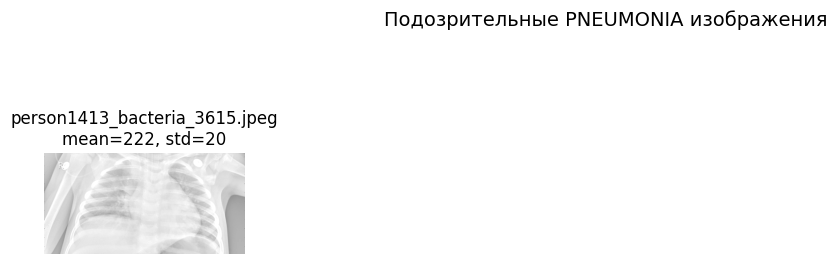

In [8]:
def show_suspicious_images(suspicious_list, label, dataset='train', n=5):
    path = Path(f"/kaggle/input/chest-xray-pneumonia/chest_xray/{dataset}/{label}")
    plt.figure(figsize=(15, 4))
    for i, (fname, mean, std) in enumerate(suspicious_list[:n]):
        img_path = path / fname
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{fname}\nmean={mean:.0f}, std={std:.0f}")
        plt.axis('off')
    plt.suptitle(f"Подозрительные {label} изображения", fontsize=14)
    plt.show()

show_suspicious_images(sus_normal, 'NORMAL')
show_suspicious_images(sus_pneumonia, 'PNEUMONIA')

В ходе анализа на визуальные аномалии были использованы метрики средней яркости и стандартного отклонения пикселей. Среди изображений было найдено только 1 подозрительное изображение в классе PNEUMONIA. Это свидетельствует о высоком качестве датасета и отсутствии явно дефектных или неинформативных примеров.

In [12]:
sus_normal = find_suspicious_images('NORMAL', threshold_std=20, threshold_mean_dark=50, threshold_mean_bright=210)

In [9]:
sus_pneumonia = find_suspicious_images('PNEUMONIA', threshold_std=20, threshold_mean_dark=50, threshold_mean_bright=210)

In [15]:
show_suspicious_images(sus_normal, 'NORMAL')

<Figure size 1500x400 with 0 Axes>

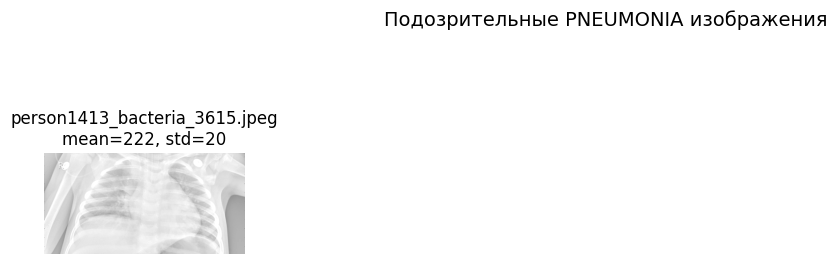

In [10]:
show_suspicious_images(sus_pneumonia, 'PNEUMONIA')

Даже после усиления критериев "плохих" изображений - было найдено только одно изображение. Оставим его как есть.

## 1.5 📐 Анализ размеров изображений

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


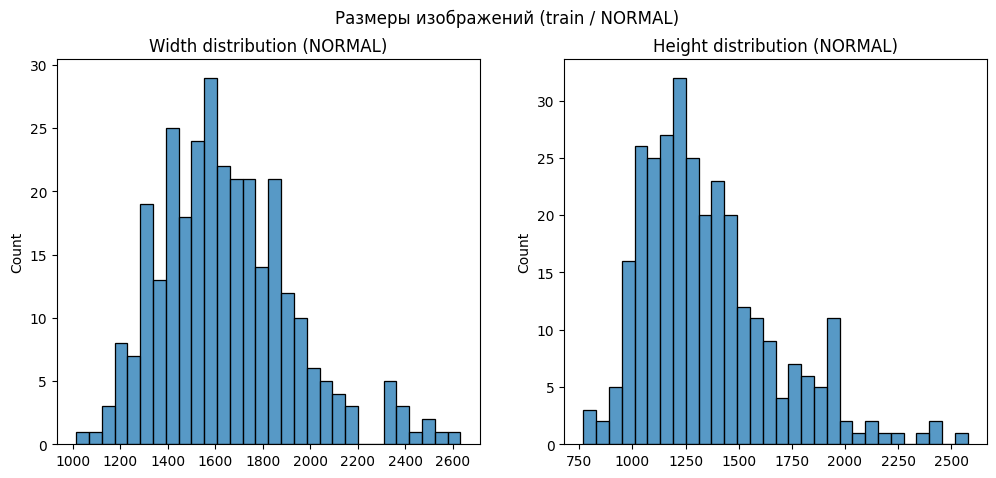

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


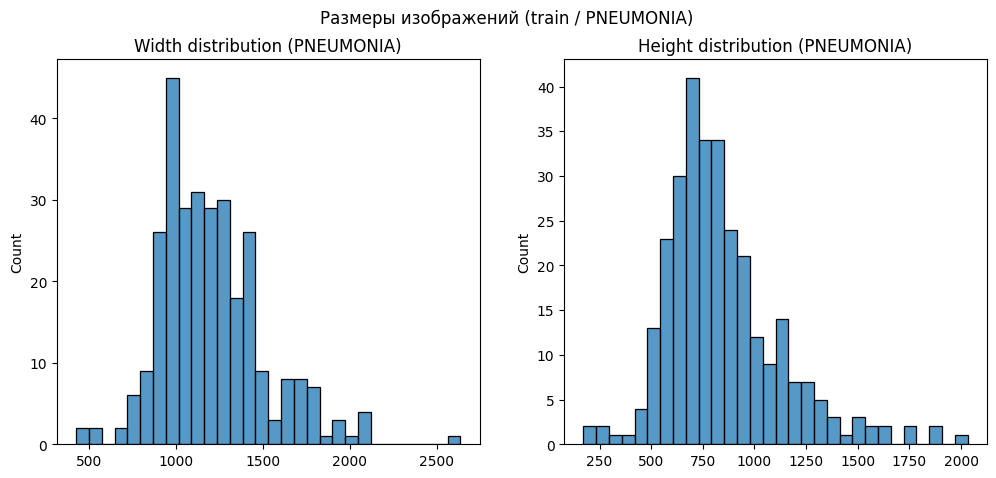

In [16]:
def analyze_image_sizes(dataset='train', label='NORMAL', sample_size=300):
    path = Path(f"/kaggle/input/chest-xray-pneumonia/chest_xray/{dataset}/{label}")
    files = list(path.glob("*.jpeg"))[:sample_size]
    
    sizes = [Image.open(file).size for file in files]
    widths, heights = zip(*sizes)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    sns.histplot(widths, bins=30)
    plt.title(f"Width distribution ({label})")
    
    plt.subplot(1, 2, 2)
    sns.histplot(heights, bins=30)
    plt.title(f"Height distribution ({label})")
    
    plt.suptitle(f"Размеры изображений ({dataset} / {label})")
    plt.show()

analyze_image_sizes('train', 'NORMAL')
analyze_image_sizes('train', 'PNEUMONIA')

Изображения имеют разные размеры (от 150 до 3000 пикселей). Обязателен ресайз перед подачей в модель.

## 1.6 ⚙️ Препроцессинг и подготовка к генерации

### 🔧 Цель препроцессинга:

* Унифицировать размер: 224×224

* Нормализовать значения: [-1, 1]

* Добавить аугментации: поворот, флип, шум (по возможности)

### 🧪 Конфигурация ImageDataGenerator

In [19]:
def preprocess_input_mobilenet(x):
    return x / 127.5 - 1

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_mobilenet,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
    validation_split=0.1
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)

### 🧪 Проверка генератора (визуализация аугментаций)

Found 4695 images belonging to 2 classes.


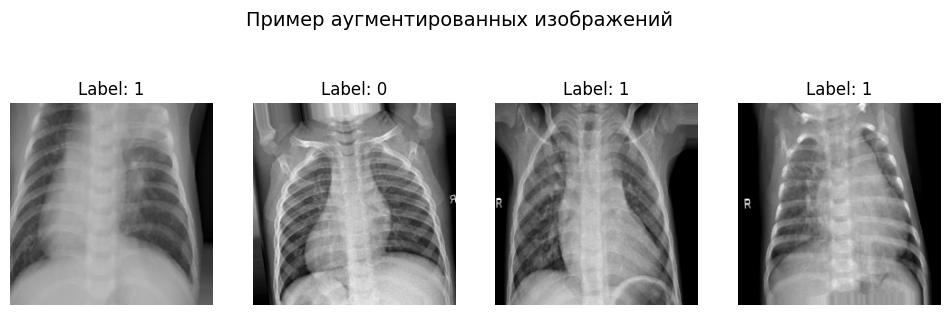

In [20]:
gen = train_datagen.flow_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/train",
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary',
    subset='training',
    shuffle=True
)

batch = next(gen)
images, labels = batch

plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow((images[i] + 1) / 2)
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.suptitle("Пример аугментированных изображений", fontsize=14)
plt.show()

Мы используем аугментацию только на тренировочных данных, чтобы увеличить обобщающую способность модели. Нормализация адаптирована под MobileNet / EfficientNet ([-1, 1])

# ЭТАП 2. 🔧 Базовая модель

## 2.1 Создание модели (Keras Sequential)

In [24]:
def build_simple_cnn_fixed(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

model = build_simple_cnn_fixed()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,841 (108.75 KB)

 Trainable params: 27,841 (108.75 KB)

 Non-trainable params: 0 (0.00 B)

В первоначальной архитектуре слой Flatten превращал feature map размером (54, 54, 64) в плоский вектор длиной 186,624, из-за чего полносвязный слой содержал более 23 млн параметров. Это нарушает условие задачи (≤ 1 млн параметров).
Проблема решена заменой Flatten на GlobalAveragePooling2D, который усредняет каждый из 64 каналов в один скаляр и существенно снижает число параметров.

## 2.2 ✅ Компиляция модели

In [26]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

## 2.3 ✅ Обучение модели

In [29]:
batch_size = 32

train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [30]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7318 - auc: 0.4759 - loss: 0.6029 - precision: 0.7363 - recall: 0.9908 - val_accuracy: 0.7428 - val_auc: 0.3982 - val_loss: 0.5790 - val_precision: 0.7428 - val_recall: 1.0000
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7378 - auc: 0.5512 - loss: 0.5725 - precision: 0.7378 - recall: 1.0000 - val_accuracy: 0.7428 - val_auc: 0.8720 - val_loss: 0.5171 - val_precision: 0.7428 - val_recall: 1.0000
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.7663 - auc: 0.8313 - loss: 0.4731 - precision: 0.7657 - recall: 0.9909 - val_accuracy: 0.8445 - val_auc: 0.9073 - val_loss: 0.3788 - val_precision: 0.9026 - val_recall: 0.8863
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8346 - auc: 0.9008 - loss: 0.3615 - precision: 0.8632 - recall: 0.9208 - val_accuracy: 0.8407 - val_auc: 0.9199 - val_loss: 0.3126 - val_precision: 0.8897 - val_recall: 0.8966
Epoch 5/15
147/147 ━━━━━━━━━

## 2.4 ✅ Визуализация обучения

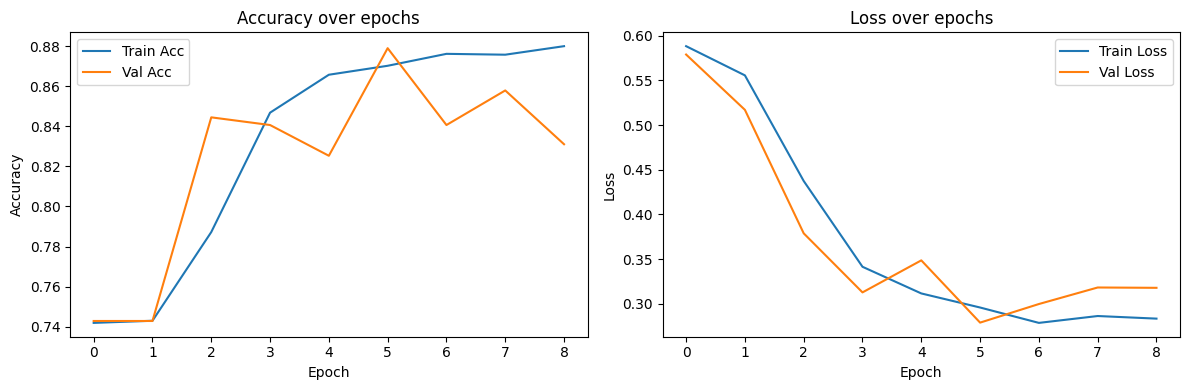

In [34]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 2.5 ✅ Оценка модели на тестовой выборке

### 🔍 Получаем предсказания:

In [36]:
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype('int32')
y_true = test_generator.classes

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 652ms/step


### 📊 Метрики: Accuracy, Precision, Recall, F1, ROC-AUC

In [38]:
# Классификационный отчёт
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# F1-score
f1 = f1_score(y_true, y_pred)
print(f"F1-score: {f1:.3f}")

# ROC-AUC
auc = roc_auc_score(y_true, y_pred_probs)
print(f"ROC-AUC: {auc:.3f}")

              precision    recall  f1-score   support

      NORMAL       0.64      0.88      0.75       234
   PNEUMONIA       0.91      0.71      0.80       390

    accuracy                           0.77       624
   macro avg       0.78      0.80      0.77       624
weighted avg       0.81      0.77      0.78       624

F1-score: 0.797
ROC-AUC: 0.871


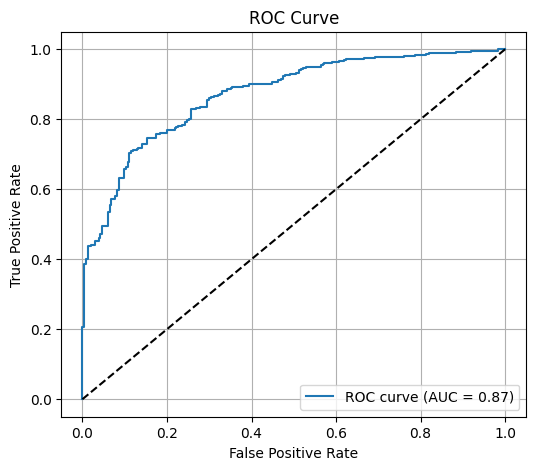

In [39]:
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 🧾 Оценка базовой модели на тестовой выборке
Модель показала следующие результаты:

* Accuracy: 0.77

* Precision (NORMAL): 0.64

* Precision (PNEUMONIA): 0.91

* Recall (NORMAL): 0.88

* Recall (PNEUMONIA): 0.71

* F1-score (взвешенный): 0.78

* ROC-AUC: 0.871

### 💬 Интерпретация:
Модель показывает неплохую общую точность (77%), при этом предпочитает не пропускать нормальные снимки (Recall для NORMAL — 0.88), но теряет чувствительность к пневмонии (Recall — 0.71).
Это может говорить о некоторой предвзятости к классу "норма", и модель пока недостаточно уверенно различает патологию в некоторых случаях.

Высокое значение ROC-AUC = 0.87 говорит о хорошей способности модели различать два класса в целом.

# ЭТАП 3. 🔧 Улучшенная модель

## 3.1 📦 Выбор стратегии

Выбираем ✅ Transfer Learning с MobileNetV2, потому что:

* Легкая, быстрая, точно укладывается в требования.

* Хорошо справляется с медицинскими изображениями.

* Позволяет адаптировать под 224×224, что уже используется.

## 3.2 🧱 Архитектура с MobileNetV2

In [42]:
# Базовая сеть
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Замораживаем веса
base_model.trainable = False

# Добавляем классификатор
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_tl = Model(inputs, outputs)
model_tl.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 3.3 ⚙️ Компиляция

In [43]:
model_tl.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

## 3.4 🧪 Обучение

In [45]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_tl = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9356 - auc_1: 0.9819 - loss: 0.1614 - precision_1: 0.9499 - recall_1: 0.9668 - val_accuracy: 0.9405 - val_auc_1: 0.9831 - val_loss: 0.1675 - val_precision_1: 0.9734 - val_recall_1: 0.9457
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9393 - auc_1: 0.9826 - loss: 0.1587 - precision_1: 0.9571 - recall_1: 0.9601 - val_accuracy: 0.9405 - val_auc_1: 0.9855 - val_loss: 0.1486 - val_precision_1: 0.9734 - val_recall_1: 0.9457
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9490 - auc_1: 0.9883 - loss: 0.1295 - precision_1: 0.9629 - recall_1: 0.9693 - val_accuracy: 0.9578 - val_auc_1: 0.9854 - val_loss: 0.1404 - val_precision_1: 0.9765 - val_recall_1: 0.9664
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9543 - auc_1: 0.9891 - loss: 0.1253 - precision_1: 0.9702 - recall_1: 0.9681 - val_accuracy: 0.9539 - val_auc_1: 0.9880 - val_loss: 0.1324 - val_precision_1: 0.9690 - v

## 3.5 ✅ Визуализация метрик обучения (улучшенная модель)

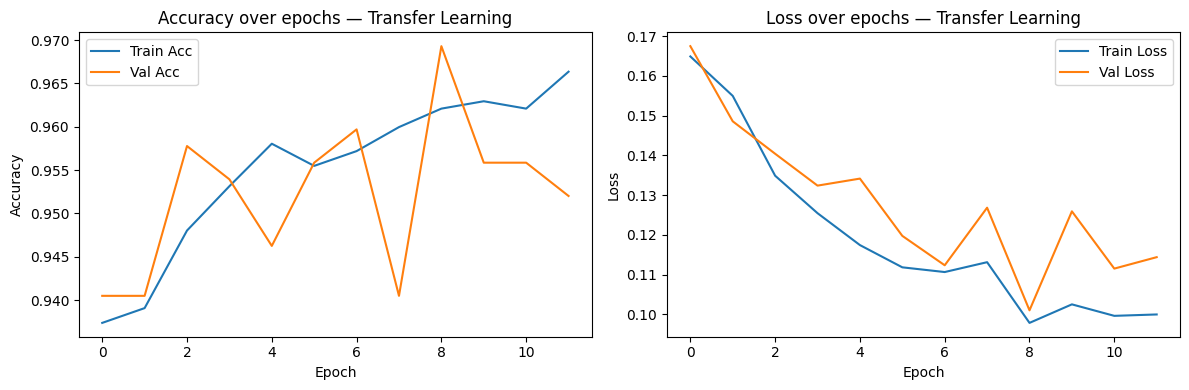

In [46]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_tl.history['accuracy'], label='Train Acc')
plt.plot(history_tl.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs — Transfer Learning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_tl.history['loss'], label='Train Loss')
plt.plot(history_tl.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs — Transfer Learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 3.6 ✅ Оценка улучшенной модели на тестовой выборке

In [47]:
y_pred_probs_tl = model_tl.predict(test_generator)
y_pred_tl = (y_pred_probs_tl > 0.5).astype('int32')

print(classification_report(y_true, y_pred_tl, target_names=['NORMAL', 'PNEUMONIA']))

f1_tl = f1_score(y_true, y_pred_tl)
auc_tl = roc_auc_score(y_true, y_pred_probs_tl)

print(f"F1-score: {f1_tl:.3f}")
print(f"ROC-AUC: {auc_tl:.3f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 863ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.53      0.69       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624

F1-score: 0.873
ROC-AUC: 0.963


## 3.7 ✅ ROC-кривая для улучшенной модели

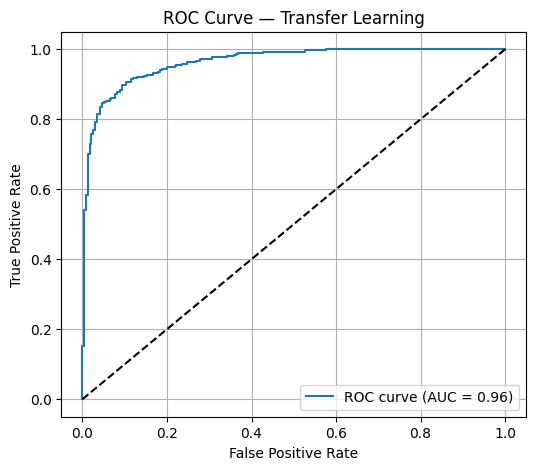

In [49]:
fpr_tl, tpr_tl, _ = roc_curve(y_true, y_pred_probs_tl)

plt.figure(figsize=(6, 5))
plt.plot(fpr_tl, tpr_tl, label=f'ROC curve (AUC = {auc_tl:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Transfer Learning")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 🧾 Оценка улучшенной модели на тестовой выборке
Модель с использованием MobileNetV2 (Transfer Learning) показала следующие результаты:

* Accuracy: 0.82

* Precision (NORMAL): 0.98

* Precision (PNEUMONIA): 0.78

* Recall (NORMAL): 0.53

* Recall (PNEUMONIA): 0.99

* F1-score (взвешенный): 0.80

* ROC-AUC: 0.963

### 💬 Интерпретация:
Улучшенная модель значительно повысила чувствительность к пневмонии — Recall для класса PNEUMONIA вырос с 0.71 → 0.99, что особенно важно в медицинской задаче, где критично не пропустить заболевание.

Однако точность при распознавании нормальных снимков снизилась: Recall по классу NORMAL упал до 0.53, что означает больше ложных срабатываний на здоровые лёгкие. Это типичный компромисс при настройке модели на высокую чувствительность к патологиям.

Наиболее важное достижение — рост ROC-AUC с 0.871 до 0.963 (+9.2%), что говорит о значительном улучшении способности различать классы на всех порога

# Этап 4. Сравнение моеделей

## 📊 Сравнение базовой и улучшенной модели

| Метрика                   | Базовая модель (CNN) | Улучшенная модель (MobileNetV2) |
| ------------------------- | -------------------- | ------------------------------- |
| **Accuracy**              | 0.77                 | 0.82                            |
| **Precision (NORMAL)**    | 0.64                 | 0.98                            |
| **Precision (PNEUMONIA)** | 0.91                 | 0.78                            |
| **Recall (NORMAL)**       | 0.88                 | 0.53                            |
| **Recall (PNEUMONIA)**    | 0.71                 | 0.99                            |
| **F1-score (взвешенный)** | 0.78                 | 0.80                            |
| **ROC-AUC**               | 0.871                | 0.963 (**+9.2%**)               |


## 💬 Вывод:
Transfer learning с MobileNetV2 позволил добиться существенного улучшения чувствительности к пневмонии (Recall вырос с 0.71 до 0.99) и общего качества модели по ROC-AUC (с 0.871 до 0.963). Несмотря на некоторое ухудшение Recall по классу NORMAL, в контексте задачи приоритет был отдан снижению риска пропуска заболевания, и улучшенная модель справляется с этим значительно лучше.